In [41]:
import numpy as np
import matplotlib.pyplot as plt

def objF(y,x,A,gamma,theta):
    return np.linalg.norm(y-np.dot(A,x))**2 + gamma*np.dot(theta.T,x) 

def discreteLineSearch(gram,corr,theta,sol,sds,sparsity):
    rhs = corr - sparsity * theta / 2
    new_solution = np.linalg.solve(gram, rhs)
    new_theta = np.sign(new_solution)
    sign_flips = np.where(abs(new_theta - theta) > 1)[0]
    if len(sign_flips) > 0:
        best_curr = new_solution
        best_obj = (sds + (np.dot(new_solution,
                                  np.dot(gram, new_solution))
                    - 2 * np.dot(new_solution,corr))
                    + sparsity * abs(new_solution).sum())
        for idx in sign_flips:
            a = new_solution[idx]
            b = sol[idx]
            prop = b / (b - a)
            curr = sol - prop * (sol - new_solution)
            cost = sds + (np.dot(curr, np.dot(gram, curr))
                          - 2 * np.dot(curr,corr)
                          + sparsity * abs(curr).sum())
            if cost < best_obj:
                best_obj = cost
                best_curr = curr
    else:
        best_curr = new_solution
    return best_curr

def featureSignSearch(A,y,gamma):
    effective_zero = 1e-18
    k,n = A.shape
    gram_matrix = np.dot(A.T, A)
    target = np.dot(A.T, y)
    x = np.zeros(n)
    theta = np.zeros(n, dtype=np.int8)
    active_set = set()
    z_opt = np.inf # Used to store gradient check for zero coefficients
    nz_opt = 0 # Used to store gradient check for non-zero coefficients
    grad = - 2 * target + 2 * np.dot(gram_matrix, x)
    sds = np.dot(y.T, y)
    obj=[]
    while z_opt > gamma or not np.allclose(nz_opt, 0):
        obj.append(objF(y,x,A,gamma,theta))
        if np.allclose(nz_opt, 0):
            candidate = np.argmax(np.abs(grad) * (theta == 0))
            if grad[candidate] > gamma:
                theta[candidate] = -1.
                x[candidate] = 0.
                active_set.add(candidate)
            elif grad[candidate] < -gamma:
                theta[candidate] = 1.
                x[candidate] = 0.
                active_set.add(candidate)
            if len(active_set) == 0:
                break
        ind= np.array(sorted(active_set))
        cut_gram = gram_matrix[np.ix_(ind, ind)]
        cut_corr = target[ind]
        cut_theta = theta[ind]
        cut_sol = x[ind]
        ############# Discrete Line Segment Search #####################
        x[ind]= discreteLineSearch(cut_gram,cut_corr,cut_theta,
                                   cut_sol,sds,gamma)
        ################################################################
        zeros = ind[np.abs(x[ind]) < effective_zero]
        x[zeros] = 0.
        theta[ind] = np.int8(np.sign(x[ind]))
        active_set.difference_update(zeros)
        grad = - 2 * target+ 2 * np.dot(gram_matrix, x)
        z_opt = np.max(abs(grad[theta == 0]))
        nz_opt = np.max(abs(grad[theta != 0] + gamma * theta[theta != 0]))
        
    plt.plot(obj)
    plt.xlabel('Iterations')
    plt.ylabel("Objective Function")
    plt.title("Value of objective function after iterations")
    plt.show()
    return x,obj[-1]

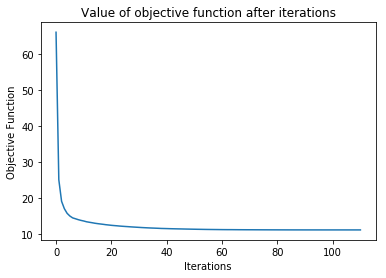

Final Value of L1 regularized error function = 11.1396


In [42]:
##### Test Case ######
k,n = 200,1000
y = np.random.random(k)
A = np.random.random((k,n))
gamma = 2.0
x,obj = featureSignSearch(A,y,gamma)
print("Final Value of L1 regularized error function = %2.4f"%obj)